In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, gc, random
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
from tf_nn_utils import *
from viterbi_utils import *
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

# set gpu memory growth
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [2]:
# configurations and main hyperparammeters
nn_epochs = 100
nn_batch_size = 16
class_num = 6
LR = 0.001

In [3]:
df_train_raw = pd.read_pickle('../features/train_clean.pkl')
df_test_raw = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test_raw[TARGET] = 0

# # RFC features
# Y_train_proba = np.load("../features/Y_train_proba.npy")
# Y_test_proba = np.load("../features/Y_test_proba.npy")
# Y_train_proba = np.delete(Y_train_proba, list(range(3500000, 4000000)), 0)
# for i in range(11):
#     df_train_raw[f"proba_{i}"] = Y_train_proba[:, i]
#     df_test_raw[f"proba_{i}"] = Y_test_proba[:, i]

print(f"train size:{df_train_raw.shape}, test size:{df_test_raw.shape}")

train size:(4500000, 6), test size:(2000000, 7)


In [4]:
# feature engineering here
def fe(df, is_train):

    df["group"] = df["batch"].astype("str") + "_" + df["mini_batch"].astype("str")
    
    # shift features
    for shift_val in range(1, 11):
        group_on = "batch" if is_train else "group"
        df[f'shift+{shift_val}'] = df.groupby([group_on])['signal'].shift(shift_val).fillna(0)
        df[f'shift_{shift_val}'] = df.groupby([group_on])['signal'].shift(-shift_val).fillna(0)
        
    return df

df_train_raw = fe(df_train_raw, is_train=1)
df_test_raw = fe(df_test_raw, is_train=0)

In [5]:
BATCH_GROUP = [6, 9]
df_train_raw = df_train_raw[df_train_raw.batch.isin(BATCH_GROUP)].reset_index(drop=True)
TEST_GROUP = ["1_3", "2_2"]
df_test_raw = df_test_raw[df_test_raw.group.isin(TEST_GROUP)].reset_index(drop=True)

In [6]:
# remove pink noise: for training only
import numpy.fft as fft
from scipy import signal as scisig

def bandstop(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandstop")
    y = scisig.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandpass")
    y = scisig.filtfilt(b, a, x)
    return y

batch = df_train_raw[df_train_raw.batch.isin(BATCH_GROUP)]
signal = batch.signal.values
channel = batch.open_channels.values

def Arrange_mean(signal, channels, sig_mean, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] -= sig_mean[i]
    return signal_out


sig_mean = [-2.73, -1.5, -0.268, 0.96, 2.2, 3.43]
sig_noise = Arrange_mean(signal, channel, sig_mean, class_num)

sig_filter = bandstop(sig_noise)
sig_noise_white = bandpass(sig_noise)

def Recover_mean(signal, channels, sig_mean, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] += sig_mean[i]
    return signal_out

sig_recover = Recover_mean(sig_filter, channel, sig_mean, class_num)

df_train_raw.loc[df_train_raw.batch.isin(BATCH_GROUP), "signal"] = sig_recover

In [7]:
use_cols = [
    col for col in df_train_raw.columns if col not in
    ["time", "local_time", "open_channels", "batch", "mini_batch", "group", "oof"]
]
print("Used columns is", use_cols)

Used columns is ['signal', 'shift+1', 'shift_1', 'shift+2', 'shift_2', 'shift+3', 'shift_3', 'shift+4', 'shift_4', 'shift+5', 'shift_5', 'shift+6', 'shift_6', 'shift+7', 'shift_7', 'shift+8', 'shift_8', 'shift+9', 'shift_9', 'shift+10', 'shift_10']


In [8]:
proba_cols = ["proba_" + str(i) for i in range(class_num)]
for col in proba_cols:
    df_train_raw[col] = 0
    df_test_raw[col] = 0

kf = GroupKFold(n_splits=5)

for index, (tr_idx, val_idx) in enumerate(
        kf.split(df_train_raw, df_train_raw[TARGET],
                  df_train_raw["group"])):
    print("Running folder", index , ": Evaluate on", np.unique(df_train_raw["group"][val_idx]))
    clf = RandomForestClassifier(n_estimators=200,
                                 max_depth=19,
                                 max_features=10,
                                 random_state=42,
                                 n_jobs=-1,
                                 verbose=0)
    clf.fit(df_train_raw.loc[tr_idx][use_cols], df_train_raw.loc[tr_idx][TARGET])
    df_train_raw.loc[val_idx, proba_cols] = clf.predict_proba(df_train_raw.loc[val_idx][use_cols])
    df_test_raw.loc[:, proba_cols] = clf.predict_proba(df_test_raw[use_cols]) / kf.n_splits
    
use_cols = proba_cols + ["signal"]

Running folder 0 : Evaluate on ['6_5' '9_5']
Running folder 1 : Evaluate on ['6_4' '9_4']
Running folder 2 : Evaluate on ['6_3' '9_3']
Running folder 3 : Evaluate on ['6_2' '9_2']
Running folder 4 : Evaluate on ['6_1' '9_1']


In [9]:
viterbi_cols = ["viterbi_" + str(i) for i in range(class_num)]
for col in viterbi_cols:
    df_train_raw[col] = 0
    df_test_raw[col] = 0

signal = df_train_raw["signal"].values
state = df_train_raw[TARGET].values
viterbi = PosteriorDecoder().fit(signal, state)
# df_train_raw.loc[:, viterbi_cols], df_train_raw.loc[:, "oof"] = viterbi.predict(signal)

kf = GroupKFold(n_splits=5)
for index, (tr_idx, val_idx) in enumerate(
        kf.split(df_train_raw, df_train_raw[TARGET],
                  df_train_raw["group"])):

    print("Running folder", index , ": Evaluate on", np.unique(df_train_raw["group"][val_idx]))

    signal_valid = df_train_raw.loc[val_idx]["signal"].values
    df_train_raw.loc[val_idx, viterbi_cols], df_train_raw.loc[val_idx, "oof"] = viterbi.predict(signal_valid)
    print("F1 macro =", f1_score(y_pred=df_train_raw.loc[val_idx, "oof"], y_true=df_train_raw.loc[val_idx, TARGET], average='macro'))
#     f1_score(df_train_raw[TARGET].values, df_train_raw[viterbi_cols].values.argmax(axis=1), average='macro').round(4)
print("==> oof score is", f1_score(df_train_raw[TARGET].values, df_train_raw["oof"].values, average='macro').round(4))

# predict test
for col in TEST_GROUP:
    df_test_raw.loc[df_test_raw.group == col, viterbi_cols], df_test_raw.loc[df_test_raw.group == col, "oof"] = viterbi.predict(df_test_raw.loc[df_test_raw.group == col, "signal"].values)

use_cols = use_cols + viterbi_cols

Running folder 0 : Evaluate on ['6_5' '9_5']
F1 macro = 0.9727157820330236
Running folder 1 : Evaluate on ['6_4' '9_4']
F1 macro = 0.9706492214230243
Running folder 2 : Evaluate on ['6_3' '9_3']
F1 macro = 0.9725835801917541
Running folder 3 : Evaluate on ['6_2' '9_2']
F1 macro = 0.9722172177089169
Running folder 4 : Evaluate on ['6_1' '9_1']
F1 macro = 0.9734421388164555
==> oof score is 0.9724


In [10]:
min_max_scaler = MinMaxScaler()
df_train_raw[viterbi_cols] = min_max_scaler.fit_transform(df_train_raw[viterbi_cols].values.T).T
df_test_raw[viterbi_cols] = min_max_scaler.fit_transform(df_test_raw[viterbi_cols].values.T).T
# min_max_scaler.fit(df_train_raw[viterbi_cols].values.T)
# df_train_raw[viterbi_cols] = min_max_scaler.transform(df_train_raw[viterbi_cols].values.T).T
# df_test_raw[viterbi_cols] = min_max_scaler.transform(df_test_raw[viterbi_cols].values.T).T

In [11]:
# cluster_num = 18
# kmean_cols = ["kmean_" + str(i) for i in range(cluster_num)]
# for col in kmean_cols:
#     df_train_raw[col] = 0
#     df_test_raw[col] = 0

# # k means
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=cluster_num, random_state=42).fit(df_train_raw.signal.values.reshape([-1,1]))

# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# df_train_raw[kmean_cols] = enc.fit_transform(kmeans.labels_.reshape([-1,1])).toarray()
##############################################################
# fuzzy c means
# cluster_num = 6
# fcm_cols = ["fcm_" + str(i) for i in range(cluster_num)]
# for col in fcm_cols:
#     df_train_raw[col] = 0
#     df_test_raw[col] = 0
    
# from fcmeans import FCM
# fcm = FCM(n_clusters=cluster_num)
# fcm.fit(df_train_raw.signal.values.reshape([-1,1]))

# df_train_raw[fcm_cols] = fcm.u.round(3)

---

In [12]:
SEQ_LEN = 500
def chop_seq(df_batch_i, is_train):

    df_batch_i_features = []
    df_batch_i_y = []
    df_batch_i_group = []
    
    WHOLE_LEN = 5e5 if is_train else 1e5
    
    for i in range(int(WHOLE_LEN/SEQ_LEN)):

        # (SEQ_LEN, 5)
        tmp = df_batch_i[(SEQ_LEN * i):(SEQ_LEN * (i + 1))]
        df_batch_i_features.append(tmp[use_cols].values)
        df_batch_i_y.append(tmp[TARGET].values)
        df_batch_i_group.append(tmp["group"].values)

    return df_batch_i_features, df_batch_i_y, df_batch_i_group

In [13]:
# TRAIN
df_train = []
df_train_y = []
groups = []

for batch_i in BATCH_GROUP:
    df_batch_i = df_train_raw[df_train_raw.batch == batch_i]
    df_batch_i_features, df_batch_i_y, df_batch_i_group = chop_seq(df_batch_i, is_train=1)
    df_train.append(df_batch_i_features)
    df_train_y.append(df_batch_i_y)
    groups.append(df_batch_i_group)

df_train = np.array(df_train).reshape(
    [-1, SEQ_LEN, np.array(df_train).shape[-1]])
df_train_y = np.array(df_train_y).reshape([-1, SEQ_LEN])
groups = np.array(groups).reshape([-1, SEQ_LEN])[:,0]

print("TRAIN:", df_train.shape, df_train_y.shape)

TRAIN: (2000, 500, 13) (2000, 500)


In [14]:
# TEST
df_test = []
df_test_y = []
df_test_groups = []

mini_batch_list = [[1,3], [2,2]]
for batch_i, mini_batch_i in mini_batch_list:
    df_batch_i = df_test_raw[(df_test_raw.batch == batch_i) & (df_test_raw.mini_batch == mini_batch_i)]
    df_batch_i_features, df_batch_i_y, df_test_batch_i_group = chop_seq(df_batch_i, is_train=0)
    df_test.append(df_batch_i_features)
    df_test_y.append(df_batch_i_y)
    df_test_groups.append(df_test_batch_i_group)

df_test = np.array(df_test).reshape(
    [-1, SEQ_LEN, np.array(df_test).shape[-1]])
df_test_y = np.array(df_test_y).reshape([-1, SEQ_LEN])
df_test_groups = np.array(df_test_groups).reshape([-1, SEQ_LEN])[:,0]

print("TEST:", df_test.shape, df_test_y.shape)

TEST: (400, 500, 13) (400, 500)


In [15]:
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 5, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 5, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    out = Dense(class_num, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

In [16]:
K.clear_session()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(sess)
oof_ = np.zeros([df_train.shape[0], df_train.shape[1], class_num])
preds_ = np.zeros((df_test.shape[0] * df_test.shape[1], class_num))

In [17]:
df_train_y = pd.get_dummies(df_train_y.reshape([-1])).values.reshape([-1, SEQ_LEN, class_num])
df_test_y = np.zeros([df_train_y.shape[0], df_train_y.shape[1], class_num])

In [18]:
gkf = GroupKFold(n_splits=5)

for index, (tr_idx, val_idx) in enumerate(gkf.split(df_train, df_train_y, groups)):
    train_x, train_y = df_train[tr_idx], df_train_y[tr_idx]
    valid_x, valid_y = df_train[val_idx], df_train_y[val_idx]
    print("Running folder", index , ": Evaluate on", np.unique(groups[val_idx]))
    print(f'Our training dataset shape is {train_x.shape}')
    print(f'Our validation dataset shape is {valid_x.shape}')
    
    shape_ = (None, train_x.shape[2])
    model = Classifier(shape_)
    cb_lr_schedule = LearningRateScheduler(lr_schedule)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    checkpoint_filepath = 'best_model.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.fit(train_x,train_y,
              epochs = nn_epochs,
              callbacks = [cb_lr_schedule, early_stop, model_checkpoint_callback], #MacroF1(model, valid_x, valid_y) 
              batch_size = nn_batch_size,verbose = 0,
              validation_data = (valid_x,valid_y))
    model.load_weights(checkpoint_filepath)

    preds_f = model.predict(valid_x)
    f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') 
    print(f'Training fold {index + 1} completed. macro f1 score : {f1_score_ :1.5f}')
    oof_[val_idx] += preds_f
    te_preds = model.predict(df_test)
    te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
    preds_ += te_preds / gkf.n_splits

Running folder 0 : Evaluate on ['6_5' '9_5']
Our training dataset shape is (1600, 500, 13)
Our validation dataset shape is (400, 500, 13)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 00045: early stopping
Training fold 1 completed. macro f1 score : 0.97412
Running folder 1 : Evaluate on ['6_4' '9_4']
Our training dataset shape is (1600, 500, 13)
Our validation dataset shape is (400, 500, 13)
Epoch 00037: early stopping
Training fold 2 completed. macro f1 score : 0.97200
Running folder 2 : Evaluate on ['6_3' '9_3']
Our training dataset shape is (1600, 500, 13)
Our validation dataset shape is (400, 500, 13)
Epoch 00044: early stopping
Training fold 3 completed. macro f1 score : 0.97527
Running folder 3 : Evaluate on ['6_2' '9_2']
Our training dataset shape is (1600, 500, 13)
Our validation dataset shape is (400, 500, 13)
Epoch 00033: early stopping
Training fold 4 completed. macro f1 score : 0.97388
Running folder 4 : Evaluate on ['6_1' '9_1']
Ou

In [19]:
# goal: 0.9747
# hmm: 0.9723 (fwd-back-signal)
# nn: 0.9737
print("NN oof F1 score is", f1_score(df_train_y.reshape([-1,class_num]).argmax(axis=1), oof_.reshape([-1,class_num]).argmax(axis=1), average = 'macro').round(5))

NN oof F1 score is 0.97402


In [25]:
oof_pred = oof_.reshape([-1,class_num]).argmax(axis=1)
test_pred = preds_.argmax(axis=1)
df_test_raw.loc[df_test_raw.group.isin(["1_3", "2_2"]), TARGET] = test_pred
print(f"oof shape is {oof_pred.shape}, test pred shape is {test_pred.shape}")
# # save oof and prediction
# np.save('fwd_back_oof/fwd_back_oof_model_4.npy', oof_pred)
# np.save('fwd_back_pred/fwd_back_pred_model_4.npy', test_pred)

oof shape is (1000000,), test pred shape is (200000,)


In [21]:
# visualize final predictions
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

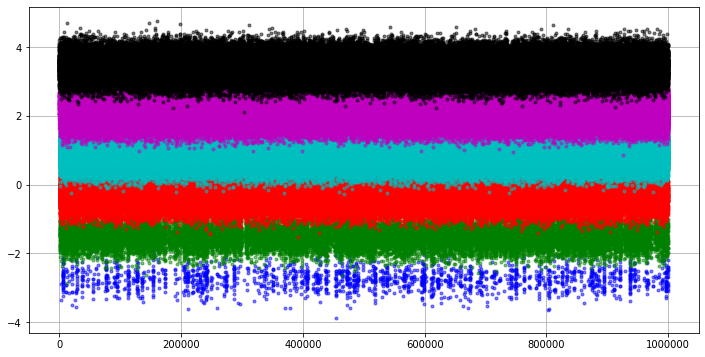

In [22]:
# target plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train_raw[df_train_raw.open_channels == channel_i].signal,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

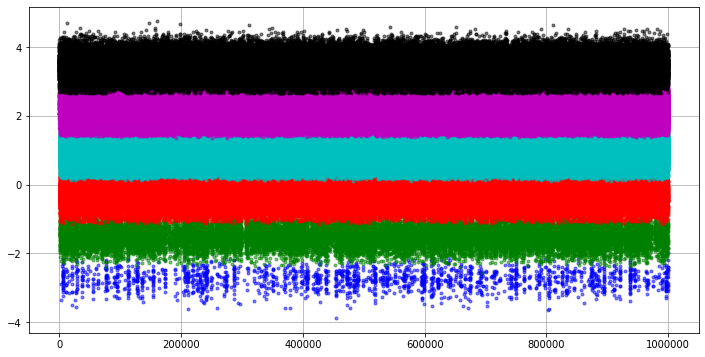

In [23]:
# oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train_raw[df_train_raw.oof == channel_i].signal,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

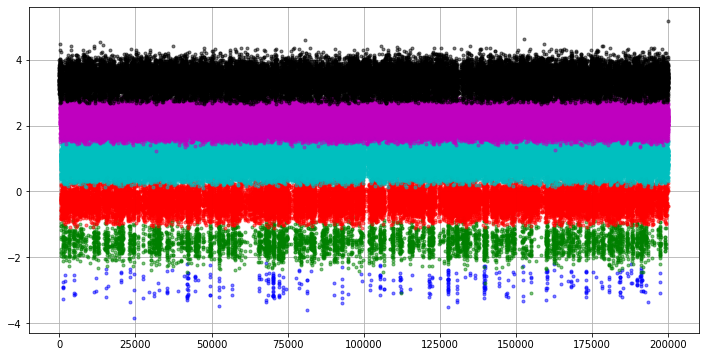

In [24]:
# test plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test_raw[(df_test_raw.open_channels == channel_i)  & (df_test_raw.group.isin(["1_3", "2_2"]))].signal,
             ".",
             color=color_list[channel_i],
             alpha=0.5)